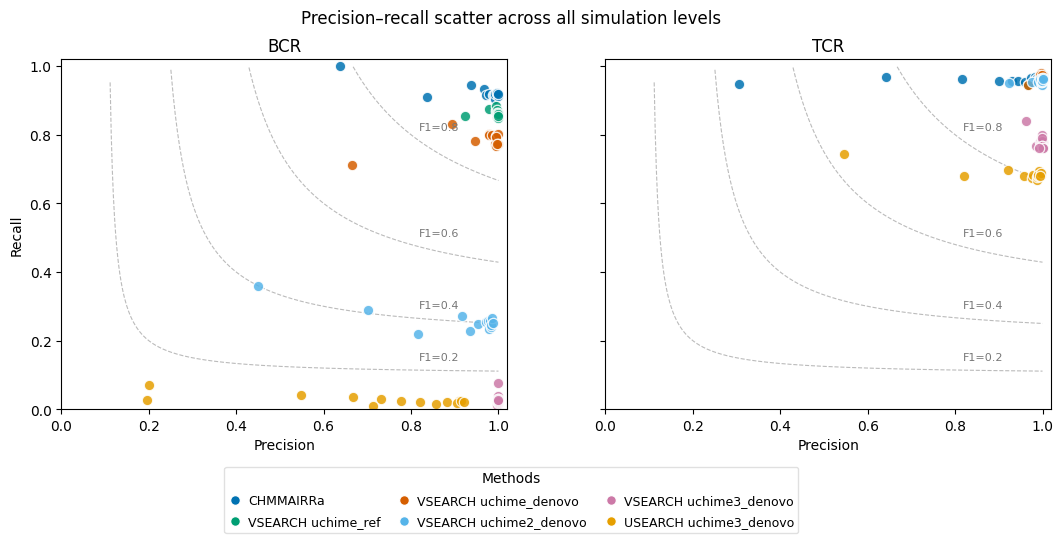

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/pr_pointcloud_BCR_TCR_side_by_side.png


In [ ]:
# === Side-by-side PR scatter: BCR | TCR ===
# requires: m (DataFrame with columns receptor, method, precision, recall),
#           method_order (list), PALETTE (dict), OUT_DIR (pathlib.Path)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

METHOD_MAP = {
    "USEARCH":         "USEARCH uchime3_denovo",
    "VSEARCH_denovo":  "VSEARCH uchime_denovo",
    "VSEARCH_uchime2": "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3": "VSEARCH uchime3_denovo",
    "VSEARCH_ref":     "VSEARCH uchime_ref",
}

preferred = [
    "CHMMAIRRa",
    "VSEARCH uchime_ref",
    "VSEARCH uchime_denovo",
    "VSEARCH uchime2_denovo",
    "VSEARCH uchime3_denovo",
    "USEARCH uchime3_denovo",
]
PALETTE = {
    "CHMMAIRRa":               "#0072B2",  # blue
    "USEARCH uchime3_denovo":  "#E69F00",  # orange
    "VSEARCH uchime_ref":      "#009E73",  # green
    "VSEARCH uchime_denovo":   "#D55E00",  # vermillion/red
    "VSEARCH uchime2_denovo":  "#56B4E9",  # sky blue
    "VSEARCH uchime3_denovo":  "#CC79A7",  # reddish purple
}

def _add_f1_isolines(ax, show=True):
    if not show:
        return
    ps = np.linspace(0.01, 1.0, 400)
    for f in [0.2, 0.4, 0.6, 0.8]:
        rs = (f*ps) / (2*ps - f)
        rs[(rs<=0) | (rs>1)] = np.nan
        ax.plot(ps, rs, linestyle="--", linewidth=0.8, color="#bbbbbb", zorder=1)
        idx = np.nanargmin(np.abs(ps - 0.82))
        if not np.isnan(rs[idx]):
            ax.text(ps[idx], min(rs[idx]+0.03, 0.98), f"F1={f:.1f}",
                    fontsize=8, color="#777777")

def pr_pointcloud_side_by_side(jitter=0.003, point_size=56, alpha=0.85, show_f1=True):
    recs = ["BCR", "TCR"]
    subs = {r: m[m["receptor"]==r].copy() for r in recs}

    # Methoden-Namen mappen
    for r in recs:
        subs[r]["method"] = subs[r]["method"].replace(METHOD_MAP)

    # union of methods present 
    present = set().union(*(set(df["method"].unique()) for df in subs.values()))
    methods_present = [mm for mm in preferred if mm in present]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    rng = np.random.default_rng(42)

    for ax, rec in zip(axes, recs):
        sub = subs[rec]
        _add_f1_isolines(ax, show=show_f1)

        for meth in methods_present:
            g = sub[sub["method"]==meth][["precision","recall"]].dropna()
            if g.empty:
                continue
            x = g["precision"].to_numpy()
            y = g["recall"].to_numpy()
            if jitter > 0:
                x = np.clip(x + rng.normal(0, jitter, len(x)), 0, 1)
                y = np.clip(y + rng.normal(0, jitter, len(y)), 0, 1)
            ax.scatter(
                x, y,
                s=point_size, alpha=alpha,
                color=PALETTE.get(meth, "#333333"),
                edgecolor="white", linewidth=0.9,
                label=meth, zorder=2
            )

        ax.set_xlim(0, 1.02)
        ax.set_ylim(0, 1.02)
        ax.set_xlabel("Precision")
        ax.set_title(f"{rec}")

    axes[0].set_ylabel("Recall")
    fig.suptitle("Precision–recall scatter across all simulation levels", y=0.98)

 
    legend_handles = [
        Line2D([0],[0], marker='o', linestyle='',
            markerfacecolor=PALETTE.get(m, '#333333'),
            markeredgecolor='white', markeredgewidth=0.9,
            markersize=7, label=m)
        for m in methods_present
    ]

    # Legende mit 2 Zeilen
    fig.legend(
        legend_handles, methods_present,
        loc="lower center", bbox_to_anchor=(0.5, -0.08),
        ncol=3,               
        frameon=True, framealpha=0.9, edgecolor="#dddddd",
        title="Methods", title_fontsize=10, fontsize=9,
        handlelength=1.0, handletextpad=0.55,
        columnspacing=1.4,
        labelspacing=0.7, borderpad=0.35
    )

    fig.subplots_adjust(bottom=0.18, right=0.95, wspace=0.22)

    out = OUT_DIR / "pr_pointcloud_BCR_TCR_side_by_side.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")

# run it
pr_pointcloud_side_by_side()


/tmp/ipykernel_112321/4260956827.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_counts).reset_index(drop=True))
/tmp/ipykernel_112321/4260956827.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wide = (m.groupby(["receptor", "method"])[metric].mean().unstack("receptor"))


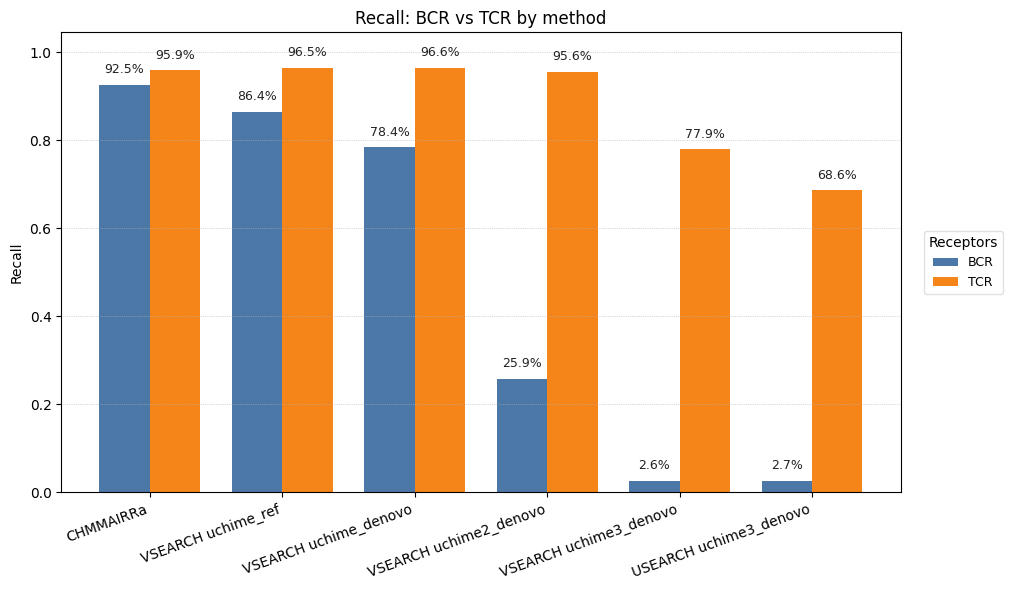

/tmp/ipykernel_112321/4260956827.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wide = (m.groupby(["receptor", "method"])[metric].mean().unstack("receptor"))


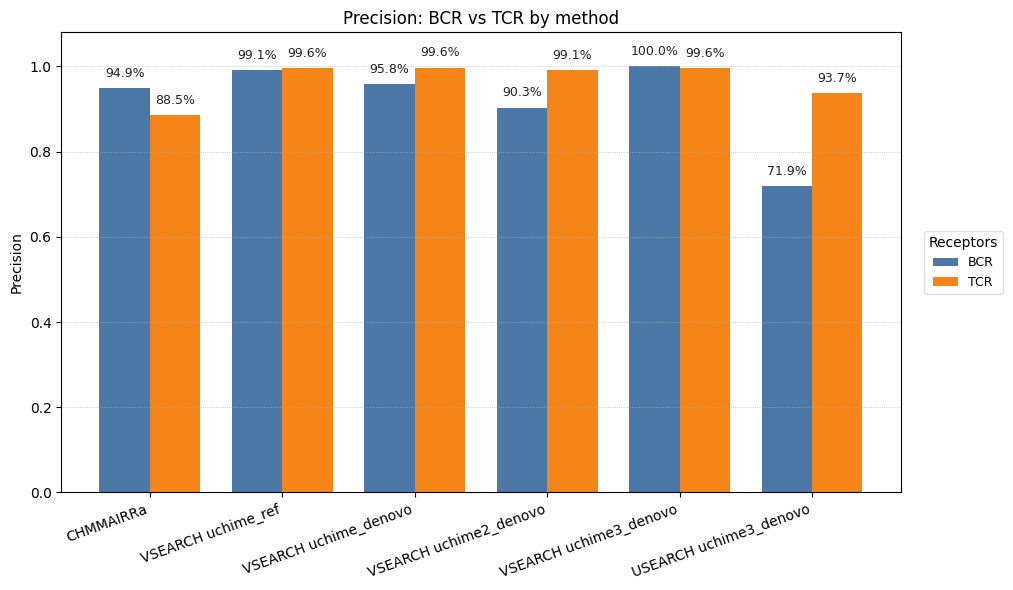

/tmp/ipykernel_112321/4260956827.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wide = (m.groupby(["receptor", "method"])[metric].mean().unstack("receptor"))


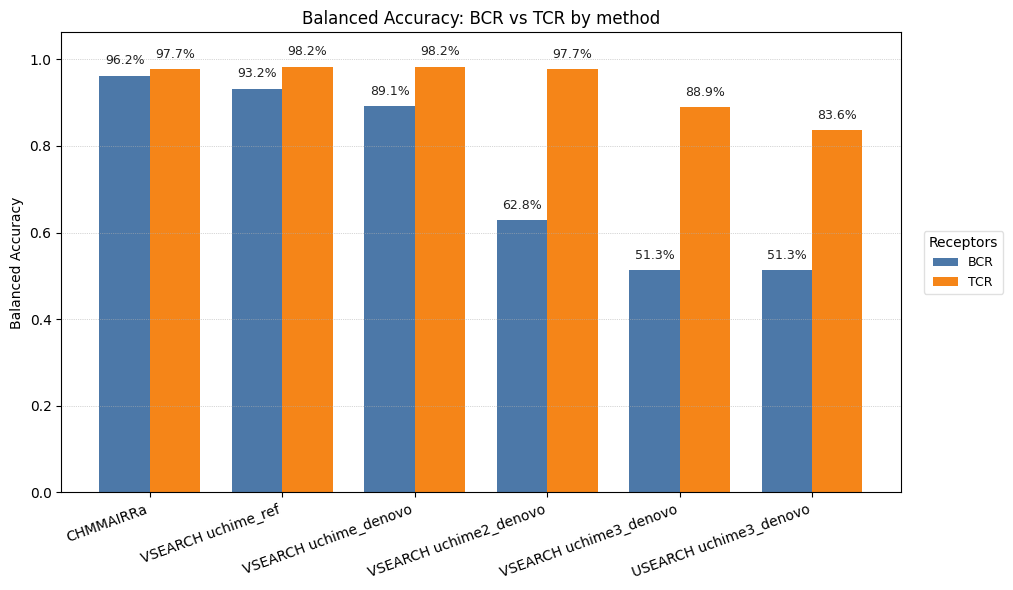

/tmp/ipykernel_112321/4260956827.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wide = (m.groupby(["receptor", "method"])[metric].mean().unstack("receptor"))


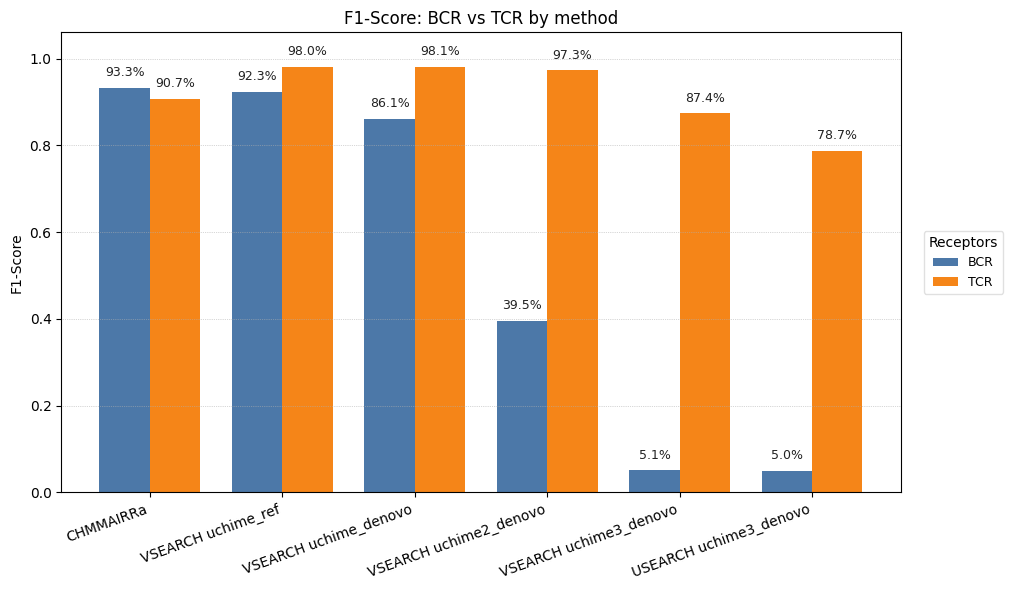

/tmp/ipykernel_112321/4260956827.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  overall = (m.groupby(["receptor","method"], as_index=False)


,receptor,method,recall,precision,bal_acc,f1
0,BCR,CHMMAIRRa,0.925400,0.948831,0.961878,0.933057
1,BCR,VSEARCH uchime_ref,0.864063,0.990941,0.931888,0.923057
2,BCR,VSEARCH uchime_denovo,0.784009,0.957956,0.891266,0.860872
3,BCR,VSEARCH uchime2_denovo,0.258650,0.902551,0.628463,0.395130
4,BCR,VSEARCH uchime3_denovo,0.026234,1.000000,0.513117,0.050741
5,BCR,USEARCH uchime3_denovo,0.027009,0.718923,0.512940,0.049632
8,TCR,VSEARCH uchime_denovo,0.965564,0.996243,0.982398,0.980655
7,TCR,VSEARCH uchime_ref,0.965062,0.996224,0.982147,0.980389
9,TCR,VSEARCH uchime2_denovo,0.955893,0.990935,0.977042,0.973004
6,TCR,CHMMAIRRa,0.958863,0.884903,0.976759,0.907261


/tmp/ipykernel_112321/4260956827.py:223: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_counts).reset_index(drop=True))
/tmp/ipykernel_112321/4260956827.py:270: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base = (sub.groupby("method", as_index=False)



Fertig ✅  — BCR/TCR-Grouped Bars (Legende rechts außen) + Tabellen gespeichert in: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics


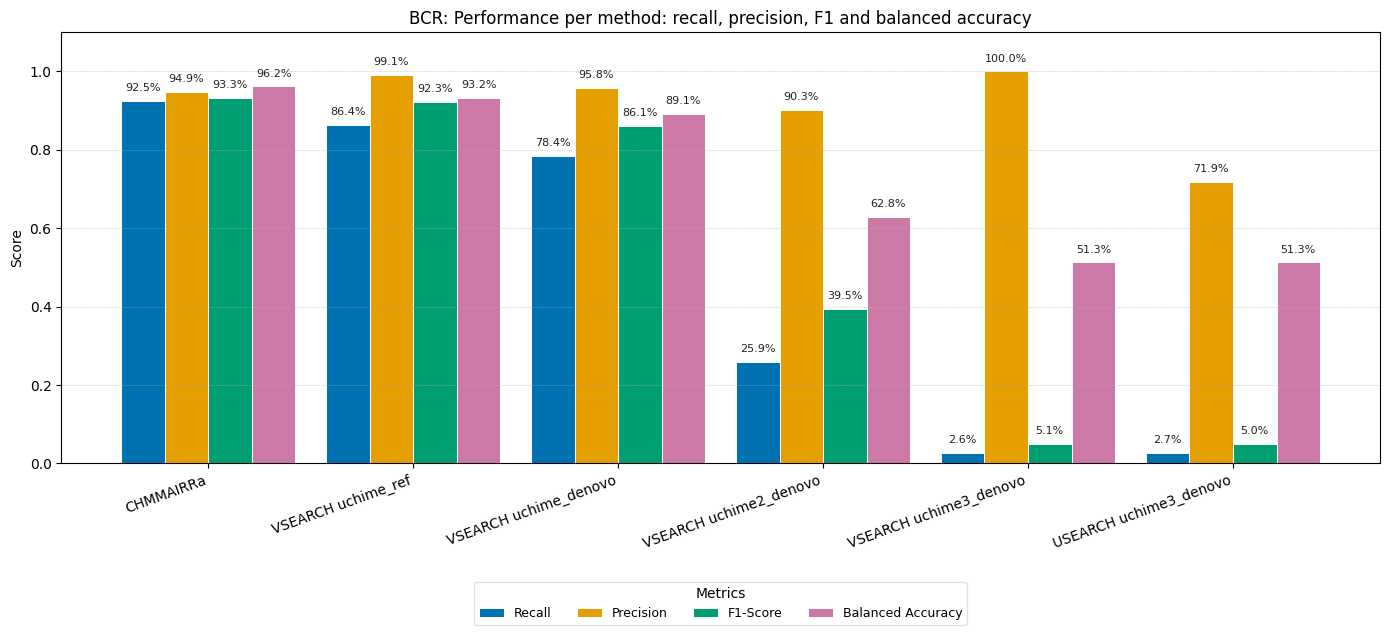

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/bcr_methods_all_metrics_overall.png


/tmp/ipykernel_112321/4260956827.py:270: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base = (sub.groupby("method", as_index=False)


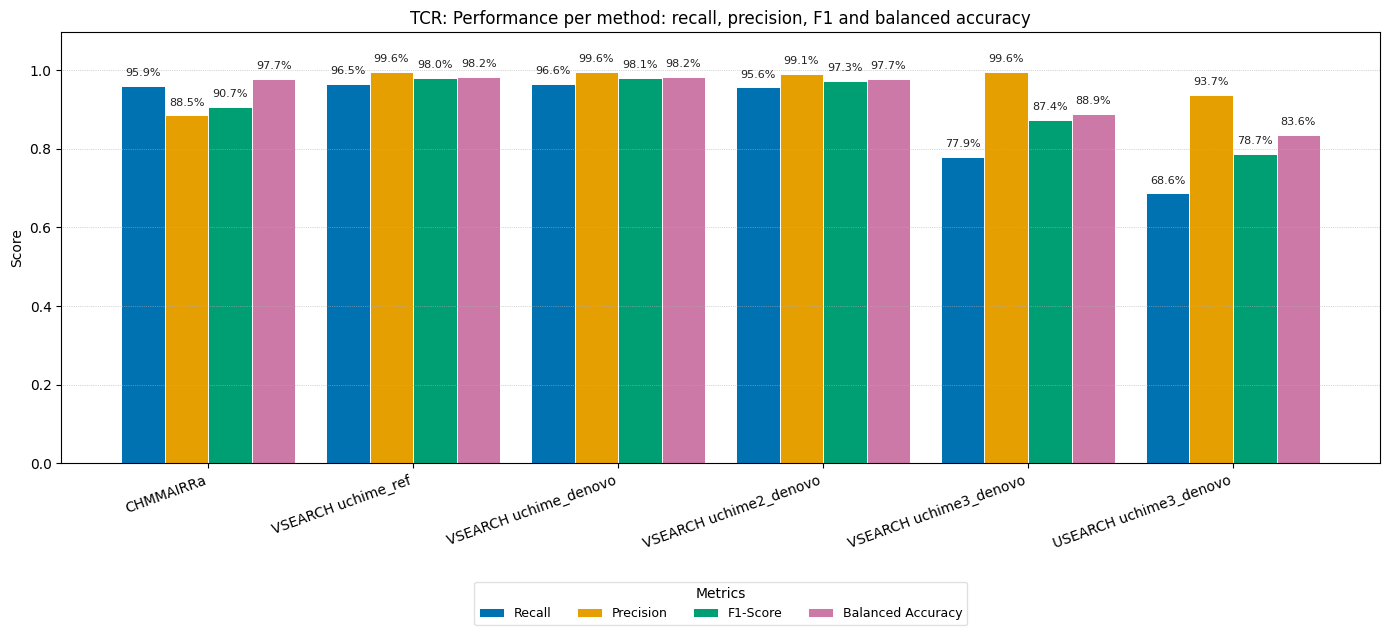

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/tcr_methods_all_metrics_overall.png


In [ ]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

IN_CSV  = Path("/home-link/zxozk31/Analyse_cons_count/Results_analyse/all_metrics.csv")
OUT_DIR = Path("/home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics")
OUT_DIR.mkdir(parents=True, exist_ok=True)


df = pd.read_csv(IN_CSV)
for c in ["TP","FP","TN","FN","n_total","n_chim","n_nonchim","sim_percent"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

METHOD_MAP = {
    "USEARCH":         "USEARCH uchime3_denovo",
    "VSEARCH_denovo":  "VSEARCH uchime_denovo",
    "VSEARCH_uchime2": "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3": "VSEARCH uchime3_denovo",
    "VSEARCH_ref":     "VSEARCH uchime_ref",
}
df["method"] = df["method"].replace(METHOD_MAP)

#  sim_percent 0.1 & 0.5 raus 
mask = ~np.isclose(df["sim_percent"], 0.1, atol=1e-9) & ~np.isclose(df["sim_percent"], 0.5, atol=1e-9)
df = df[mask].copy()


def infer_receptor(row) -> str:
    s = f"{row.get('sample','')}_{row.get('sample_base','')}".lower()
    if "bcr" in s or "_ig_" in s or "igblast_ig" in s: return "BCR"
    if "tcr" in s or "_tr_" in s or "igblast_tr" in s: return "TCR"
    return "UNK"
df["receptor"] = df.apply(infer_receptor, axis=1)


def agg_counts(g: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "TP": g["TP"].sum(), "FP": g["FP"].sum(),
        "TN": g["TN"].sum(), "FN": g["FN"].sum()
    })
by_p = (df.groupby(["receptor","sim_percent","method"], as_index=False)
          .apply(agg_counts).reset_index(drop=True))


def div(num, den):
    den = den.replace(0, np.nan)
    return (num/den).fillna(0.0).replace([np.inf,-np.inf], 0.0)

m = by_p.copy()
m["recall"]      = div(m["TP"], m["TP"] + m["FN"])
m["precision"]   = div(m["TP"], m["TP"] + m["FP"])
m["specificity"] = div(m["TN"], m["TN"] + m["FP"])
m["f1"]          = div(2*m["TP"], 2*m["TP"] + m["FP"] + m["FN"])
m["bal_acc"]     = (m["recall"] + m["specificity"]) / 2.0

method_order = [
    "CHMMAIRRa",
    "VSEARCH uchime_ref",
    "VSEARCH uchime_denovo",
    "VSEARCH uchime2_denovo",
    "VSEARCH uchime3_denovo",
    "USEARCH uchime3_denovo",
]
m["method"] = pd.Categorical(m["method"], categories=method_order, ordered=True)
m.sort_values(["receptor","method","sim_percent"], inplace=True)



PALETTE = {
    "CHMMAIRRa":        "#0072B2",  # blue
    "USEARCH":          "#E69F00",  # orange
    "VSEARCH_ref":      "#009E73",  # green
    "VSEARCH_denovo":   "#D55E00",  # vermillion/red
    "VSEARCH_uchime2":  "#56B4E9",  # sky blue
    "VSEARCH_uchime3":  "#CC79A7",  # reddish purple
}


METRIC_LABELS = {
    "recall":   "Recall",
    "precision":"Precision",
    "f1":       "F1-Score",
    "bal_acc":  "Balanced Accuracy",
}

def bar_overall_bcr_tcr(metric: str, show_delta=False, sort_by=None):
    """
    sort_by: None | "BCR" | "TCR" | "gap"  (gap = TCR - BCR)
    """
    label = METRIC_LABELS.get(metric, metric.title())

    # Mittelwerte je (receptor, method)
    wide = (m.groupby(["receptor", "method"])[metric].mean().unstack("receptor"))
    methods = [meth for meth in method_order if meth in wide.index]
    wide = wide.loc[methods].copy().fillna(0.0)

    if sort_by == "BCR" and "BCR" in wide:
        wide = wide.sort_values("BCR", ascending=False)
    elif sort_by == "TCR" and "TCR" in wide:
        wide = wide.sort_values("TCR", ascending=False)
    elif sort_by == "gap" and {"BCR","TCR"}.issubset(wide.columns):
        wide = (wide.assign(_gap = wide["TCR"] - wide["BCR"])
                     .sort_values("_gap", ascending=False)
                     .drop(columns="_gap"))

    x = np.arange(len(wide.index))
    width = 0.38

    # feste Farben für Rezeptoren
    color_bcr = "#4C78A8"
    color_tcr = "#F58518"

    plt.figure(figsize=(10.2, 6.0))
    ax = plt.gca()

    bcr_vals = wide.get("BCR", pd.Series(0, index=wide.index)).values
    tcr_vals = wide.get("TCR", pd.Series(0, index=wide.index)).values

    # Balken zeichnen
    bcr_bars = ax.bar(x - width/2, bcr_vals, width, label="BCR", color=color_bcr)
    tcr_bars = ax.bar(x + width/2, tcr_vals, width, label="TCR", color=color_tcr)

    # y-Limit: immer genug Luft nach oben für Labels
    max_v = float(np.nanmax(np.concatenate([bcr_vals, tcr_vals]))) if len(bcr_vals) else 1.0
    top   = max(1.02, max_v + 0.08)  
    ax.set_ylim(0, top)

    # Achsen/Optik
    ax.set_xticks(x)
    ax.set_xticklabels(wide.index, rotation=20, ha="right")
    ax.set_ylabel(label)
    ax.set_title(f"{label}: BCR vs TCR by method")
    ax.grid(axis="y", linestyle=":", linewidth=0.5)

    
    def _annotate_outside(ax, bars, vals):
        for bar, v in zip(bars, vals):
            xi = bar.get_x() + bar.get_width()/2
            ax.text(xi, v + 0.02, f"{v*100:.1f}%",
                    ha="center", va="bottom", fontsize=9, color="#222")

    _annotate_outside(ax, bcr_bars, bcr_vals)
    _annotate_outside(ax, tcr_bars, tcr_vals)

    # Legende rechts außen
    handles, labels_ = ax.get_legend_handles_labels()
    ax.legend(handles, labels_,
              loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=True, framealpha=0.9, edgecolor="#dddddd",
              title="Receptors", title_fontsize=10, fontsize=9)

    # Platz rechts für die Legende schaffen
    plt.gcf().subplots_adjust(right=0.80)

    plt.tight_layout()
    plt.savefig(OUT_DIR / f"overall_{metric}_bcr_vs_tcr_grouped.png", dpi=160, bbox_inches="tight")
    plt.show()

for met in ["recall", "precision", "bal_acc", "f1"]:
    bar_overall_bcr_tcr(met, show_delta=False, sort_by=None)  


overall = (m.groupby(["receptor","method"], as_index=False)
             .agg(recall=("recall","mean"),
                  precision=("precision","mean"),
                  bal_acc=("bal_acc","mean"),
                  f1=("f1","mean")))
display(overall.sort_values(["receptor","bal_acc","f1"], ascending=[True,False,False]))


m.to_csv(OUT_DIR / "metrics_by_receptor_simpercent.csv", index=False)
overall.to_csv(OUT_DIR / "metrics_overall_mean.csv", index=False)

print("\nFertig ✅  — BCR/TCR-Grouped Bars (Legende rechts außen) + Tabellen gespeichert in:", OUT_DIR)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


IN_CSV  = Path("/home-link/zxozk31/Analyse_cons_count/Results_analyse/all_metrics.csv")
OUT_DIR = Path("/home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics")
OUT_DIR.mkdir(parents=True, exist_ok=True)


df = pd.read_csv(IN_CSV)
for c in ["TP","FP","TN","FN","n_total","n_chim","n_nonchim","sim_percent"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)


METHOD_MAP = {
    "USEARCH":         "USEARCH uchime3_denovo",
    "VSEARCH_denovo":  "VSEARCH uchime_denovo",
    "VSEARCH_uchime2": "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3": "VSEARCH uchime3_denovo",
    "VSEARCH_ref":     "VSEARCH uchime_ref",
}
df["method"] = df["method"].replace(METHOD_MAP)

# sim_percent 0.1 & 0.5 entfernen 
mask = ~np.isclose(df["sim_percent"], 0.1, atol=1e-9) & ~np.isclose(df["sim_percent"], 0.5, atol=1e-9)
df = df[mask].copy()

def infer_receptor(row) -> str:
    s = f"{row.get('sample','')}_{row.get('sample_base','')}".lower()
    if "bcr" in s or "_ig_" in s or "igblast_ig" in s: return "BCR"
    if "tcr" in s or "_tr_" in s or "igblast_tr" in s: return "TCR"
    return "UNK"
df["receptor"] = df.apply(infer_receptor, axis=1)

def agg_counts(g: pd.DataFrame) -> pd.Series:
    return pd.Series({"TP": g["TP"].sum(), "FP": g["FP"].sum(),
                      "TN": g["TN"].sum(), "FN": g["FN"].sum()})
by_p = (df.groupby(["receptor","sim_percent","method"], as_index=False)
          .apply(agg_counts).reset_index(drop=True))

def div(num, den):
    den = den.replace(0, np.nan)
    return (num/den).fillna(0.0).replace([np.inf,-np.inf], 0.0)

m = by_p.copy()
m["recall"]      = div(m["TP"], m["TP"] + m["FN"])
m["precision"]   = div(m["TP"], m["TP"] + m["FP"])
m["specificity"] = div(m["TN"], m["TN"] + m["FP"])
m["f1"]          = div(2*m["TP"], 2*m["TP"] + m["FP"] + m["FN"])
m["bal_acc"]     = (m["recall"] + m["specificity"]) / 2.0

# Reihenfolge mit neuen Namen
method_order = [
    "CHMMAIRRa",
    "VSEARCH uchime_ref",
    "VSEARCH uchime_denovo",
    "VSEARCH uchime2_denovo",
    "VSEARCH uchime3_denovo",
    "USEARCH uchime3_denovo",
]
m["method"] = pd.Categorical(m["method"], categories=method_order, ordered=True)
m.sort_values(["receptor","method","sim_percent"], inplace=True)

# Labels & Farben
METRICS = ["recall","precision","f1","bal_acc"]
METRIC_LABELS = {"recall":"Recall","precision":"Precision","f1":"F1-Score","bal_acc":"Balanced Accuracy"}

METRIC_COLORS = {
    "recall":   "#0072B2",  # blau
    "precision":"#E69F00",  # orange
    "f1":       "#009E73",  # grün
    "bal_acc":  "#CC79A7",  # rotviolett
}

def plot_metrics_per_method_by_receptor(rec: str, average_over_levels=True, target_sim=None):
    """
    rec: 'BCR' oder 'TCR'
    average_over_levels=True -> Mittelwert über alle sim_percent
    target_sim=<float>       -> nächstliegende Stufe auswählen (nur wenn average_over_levels=False)
    """
    sub = m[m["receptor"]==rec].copy()
    if sub.empty:
        print(f"[Info] Keine Daten für {rec}."); return

    if average_over_levels:
        base = (sub.groupby("method", as_index=False)
                  .agg(recall=("recall","mean"),
                       precision=("precision","mean"),
                       f1=("f1","mean"),
                       bal_acc=("bal_acc","mean")))
        fname_suffix = "overall"
    else:
        avail = np.sort(sub["sim_percent"].unique())
        if target_sim is None:
            target_sim = float(avail[0])
        nearest = avail[np.argmin(np.abs(avail - float(target_sim)))]
        base = (sub[np.isclose(sub["sim_percent"], nearest, atol=1e-12)]
                   .groupby("method", as_index=False)[METRICS].mean())
        fname_suffix = f"at_{nearest:.3f}"

    base["method"] = pd.Categorical(base["method"], categories=method_order, ordered=True)
    base = base.sort_values("method")

    methods = base["method"].astype(str).tolist()
    x_methods = np.arange(len(methods))
    n_metrics = len(METRICS)
    width = 0.85 / n_metrics

    plt.figure(figsize=(14, 6.2))
    ax = plt.gca()

    # pro Metrik Balken platzieren
    handles = []
    for i, met in enumerate(METRICS):
        offset = (i - (n_metrics-1)/2) * width
        vals = base[met].values
        bars = ax.bar(x_methods + offset, vals, width,
                      label=METRIC_LABELS[met],
                      color=METRIC_COLORS.get(met, "#888"),
                      edgecolor="white", linewidth=0.7)
        handles.append(bars[0])
        # Prozent-Labels außen
        for xi, v in zip(x_methods + offset, vals):
            ax.text(xi, v + 0.02, f"{v*100:.1f}%",
                    ha="center", va="bottom", fontsize=8, color="#222")

    # y-Limit mit Luft für Labels
    vmax = float(np.nanmax(base[METRICS].values)) if len(base) else 1.0
    ax.set_ylim(0, max(1.02, vmax + 0.10))

    # Achsen & Raster
    ax.set_xticks(x_methods)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylabel("Score")
    ax.set_title(f"{rec}: Performance per method: recall, precision, F1 and balanced accuracy")
    ax.grid(axis="y", linestyle=":", linewidth=0.5)


    ax.legend(handles, [METRIC_LABELS[mn] for mn in METRICS],
              loc="upper center", bbox_to_anchor=(0.0, -0.38, 1.0, 0.12),
              ncol=4, frameon=True, framealpha=0.9,
              edgecolor="#dddddd", title="Metrics", title_fontsize=10, fontsize=9)
    plt.gcf().subplots_adjust(bottom=0.34)
    plt.tight_layout()
    out = OUT_DIR / f"{rec.lower()}_methods_all_metrics_{fname_suffix}.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)
   

   

plot_metrics_per_method_by_receptor("BCR", average_over_levels=True)
plot_metrics_per_method_by_receptor("TCR", average_over_levels=True)



/tmp/ipykernel_112321/2499913891.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_counts).reset_index(drop=True))
/tmp/ipykernel_112321/2499913891.py:93: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = (det.pivot_table(index="sim_percent", columns="method", values="detected_pct", aggfunc="mean")


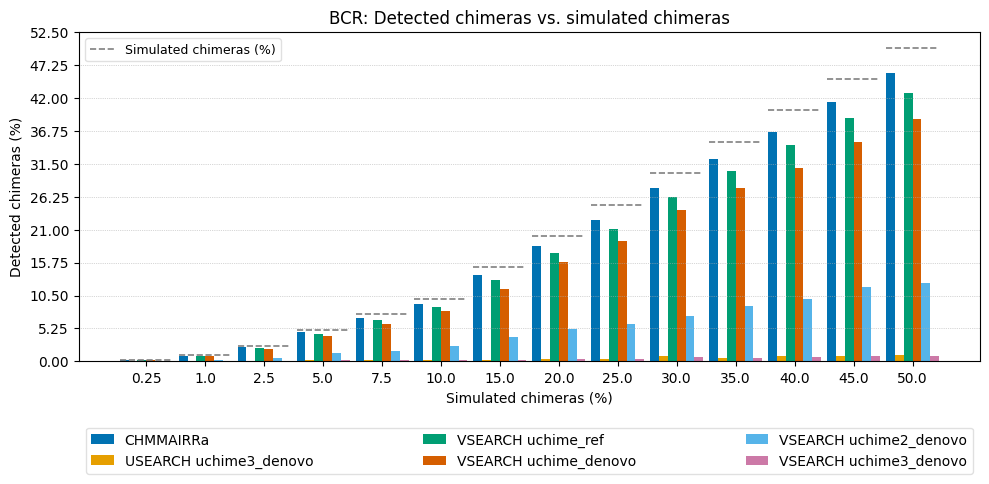

/tmp/ipykernel_112321/2499913891.py:93: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = (det.pivot_table(index="sim_percent", columns="method", values="detected_pct", aggfunc="mean")


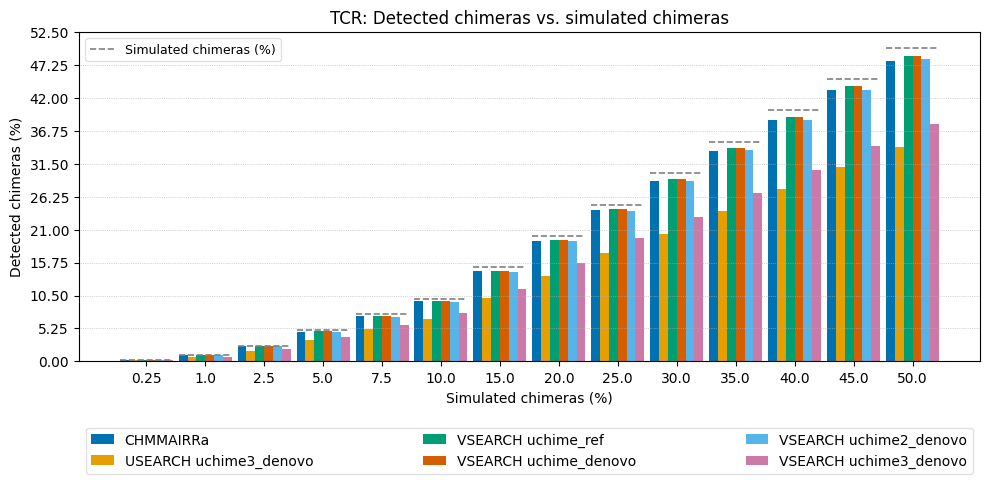


Fertig ✅ — Plots inkl. umbenannter Methoden gespeichert in: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics


In [ ]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.lines import Line2D


IN_CSV  = Path("/home-link/zxozk31/Analyse_cons_count/Results_analyse/all_metrics.csv")
OUT_DIR = Path("/home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics")
OUT_DIR.mkdir(parents=True, exist_ok=True)


df = pd.read_csv(IN_CSV)
for c in ["TP","FP","TN","FN","n_total","n_chim","n_nonchim","sim_percent"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)

# --- Mapping der Methodennamen ---
METHOD_RENAME = {
    "USEARCH":         "USEARCH uchime3_denovo",
    "VSEARCH_denovo":  "VSEARCH uchime_denovo",
    "VSEARCH_uchime2": "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3": "VSEARCH uchime3_denovo",
    "VSEARCH_ref":     "VSEARCH uchime_ref",
}
df["method"] = df["method"].replace(METHOD_RENAME)

mask = ~np.isclose(df["sim_percent"], 0.1, atol=1e-9) & ~np.isclose(df["sim_percent"], 0.5, atol=1e-9)
df = df[mask].copy()


def infer_receptor(row) -> str:
    s = f"{row.get('sample','')}_{row.get('sample_base','')}".lower()
    if "bcr" in s or "_ig_" in s or "igblast_ig" in s: return "BCR"
    if "tcr" in s or "_tr_" in s or "igblast_tr" in s: return "TCR"
    return "UNK"
df["receptor"] = df.apply(infer_receptor, axis=1)


def agg_counts(g: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "TP": g["TP"].sum(), "FP": g["FP"].sum(),
        "TN": g["TN"].sum(), "FN": g["FN"].sum()
    })
by_p = (df.groupby(["receptor","sim_percent","method"], as_index=False)
          .apply(agg_counts).reset_index(drop=True))


def div(num, den):
    den = den.replace(0, np.nan)
    return (num/den).fillna(0.0).replace([np.inf,-np.inf], 0.0)

m = by_p.copy()
m["recall"]      = div(m["TP"], m["TP"] + m["FN"])
m["precision"]   = div(m["TP"], m["TP"] + m["FP"])
m["specificity"] = div(m["TN"], m["TN"] + m["FP"])
m["f1"]          = div(2*m["TP"], 2*m["TP"] + m["FP"] + m["FN"])
m["bal_acc"]     = (m["recall"] + m["specificity"]) / 2.0


method_order = [
    "CHMMAIRRa",
    "USEARCH uchime3_denovo",
    "VSEARCH uchime_ref",
    "VSEARCH uchime_denovo",
    "VSEARCH uchime2_denovo",
    "VSEARCH uchime3_denovo",
]
m["method"] = pd.Categorical(m["method"], categories=method_order, ordered=True)
m.sort_values(["receptor","method","sim_percent"], inplace=True)


PALETTE = {
    "CHMMAIRRa":               "#0072B2",  # blue
    "USEARCH uchime3_denovo":  "#E69F00",  # orange
    "VSEARCH uchime_ref":      "#009E73",  # green
    "VSEARCH uchime_denovo":   "#D55E00",  # vermillion/red
    "VSEARCH uchime2_denovo":  "#56B4E9",  # sky blue
    "VSEARCH uchime3_denovo":  "#CC79A7",  # reddish purple
}

#  Plot: Detected vs Simulated 
def plot_detected_vs_sim_FIXED(rec: str):
    sub = m[m["receptor"]==rec]
    if sub.empty:
        return
    det = sub.copy()
    det["detected_pct"] = det["recall"] * det["sim_percent"]

    cols = [c for c in method_order if c in det["method"].unique()]
    pivot = (det.pivot_table(index="sim_percent", columns="method", values="detected_pct", aggfunc="mean")
               .reindex(columns=cols)
               .sort_index()
               .fillna(0.0))

    n_groups  = len(pivot.index)
    n_methods = len(pivot.columns)
    x_center  = np.arange(n_groups)
    bar_w     = 0.9 / max(1, n_methods)
    cluster_w = n_methods * bar_w

    plt.figure(figsize=(10, 4.8))

    # Balken
    for i, meth in enumerate(pivot.columns):
        offset = (i - (n_methods-1)/2) * bar_w
        plt.bar(
            x_center + offset,
            pivot[meth].values,
            bar_w,
            label=str(meth),
            color=PALETTE.get(str(meth))
        )

    # horizontale Referenzlinien 
    sim_vals = pivot.index.values
    for xc, yref in zip(x_center, sim_vals):
        x_left, x_right = xc - cluster_w/2, xc + cluster_w/2
        plt.hlines(y=yref, xmin=x_left, xmax=x_right,
                   colors="gray", linestyles="--", linewidth=1.2)

    ax = plt.gca()


    ref_handle = Line2D([0], [0], color="gray", linestyle="--", linewidth=1.2,
                        label="Simulated chimeras (%)")
    leg_ref = ax.legend([ref_handle], ["Simulated chimeras (%)"],
                        loc="upper left", frameon=True, framealpha=0.9,
                        edgecolor="#dddddd", fontsize=9)
    ax.add_artist(leg_ref)

    # große Methodenlegende unten
    handles, labels = ax.get_legend_handles_labels()
    hdict = {lab: h for h, lab in zip(handles, labels)}
    meth_labels  = [lab for lab in method_order if lab in hdict]
    meth_handles = [hdict[lab] for lab in meth_labels]

    ax.legend(meth_handles, meth_labels,
              loc="upper left", bbox_to_anchor=(0.0, -0.30, 1.0, 0.12),
              mode="expand", ncol=min(3, max(1, len(meth_labels))),
              frameon=True, framealpha=0.9, edgecolor="#dddddd",
              handlelength=1.6, columnspacing=1.0, labelspacing=0.5)

    plt.gcf().subplots_adjust(bottom=0.36)

    # Achsen
    plt.xticks(x_center, sim_vals)
    plt.yticks(np.linspace(0, max(sim_vals)*1.05, 11))
    plt.ylim(0, max(sim_vals)*1.05)
    plt.xlabel("Simulated chimeras (%)")
    plt.ylabel("Detected chimeras (%)")
    plt.title(f"{rec}: Detected chimeras vs. simulated chimeras")
    plt.grid(axis="y", linestyle=":", linewidth=0.5)
    plt.tight_layout()

    fname = OUT_DIR / f"{rec.lower()}_detected_vs_simulated_FIXED_hlines.png"
    plt.savefig(fname, dpi=160)
    plt.show()

# --- Aufruf ---
for rec in ["BCR","TCR"]:
    plot_detected_vs_sim_FIXED(rec)

print("\nFertig ✅ — Plots inkl. umbenannter Methoden gespeichert in:", OUT_DIR)


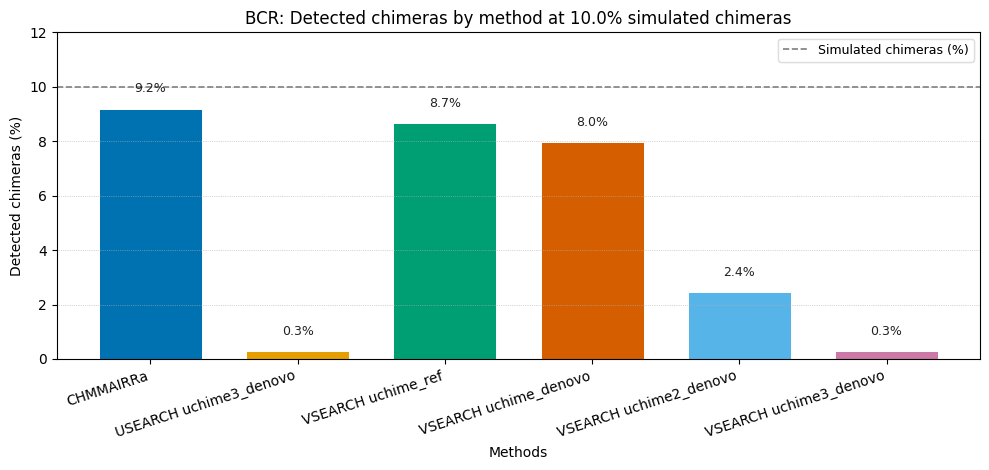

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/bcr_detected_single_level_10.0.png


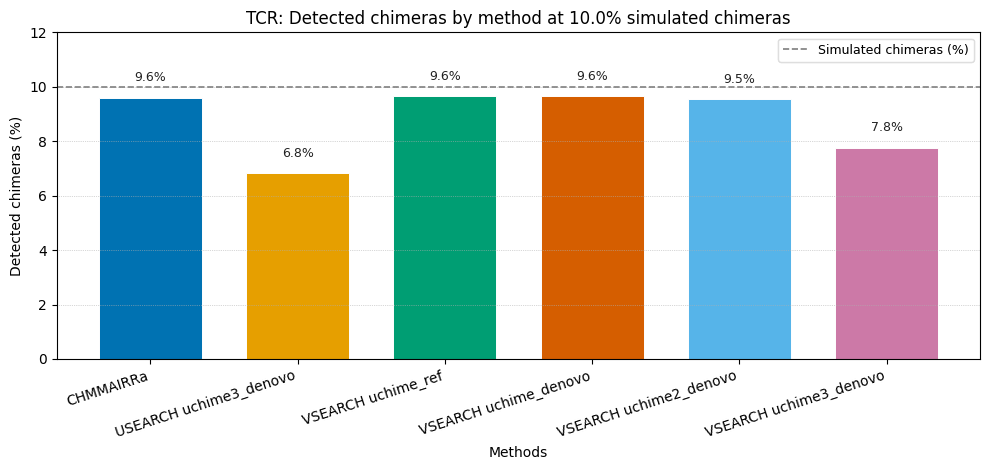

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/tcr_detected_single_level_10.0.png


In [ ]:

from matplotlib.lines import Line2D


METHOD_RENAME = {
    "USEARCH":         "USEARCH uchime3_denovo",
    "VSEARCH_denovo":  "VSEARCH uchime_denovo",
    "VSEARCH_uchime2": "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3": "VSEARCH uchime3_denovo",
    "VSEARCH_ref":     "VSEARCH uchime_ref",
}


method_order = [
    "CHMMAIRRa",
    "USEARCH uchime3_denovo",
    "VSEARCH uchime_ref",
    "VSEARCH uchime_denovo",
    "VSEARCH uchime2_denovo",
    "VSEARCH uchime3_denovo",
]

TARGET_SIM = 10.0  # z. B. 10.0, 15.0, 20.0 ...

def plot_detected_single_level(rec: str, target_sim: float):
    # pick nearest available level
    levels = np.sort(m.loc[m["receptor"]==rec, "sim_percent"].unique())
    if len(levels) == 0:
        print(f"[Info] No data for {rec}."); return
    lvl = float(levels[np.argmin(np.abs(levels - float(target_sim)))])

    sub = m[(m["receptor"]==rec) & (np.isclose(m["sim_percent"], lvl, atol=1e-10))].copy()
    if sub.empty:
        print(f"[Info] No rows for {rec} at sim≈{lvl}."); return

  
    sub["method"] = sub["method"].replace(METHOD_RENAME)

  
    sub["method"] = pd.Categorical(sub["method"], categories=method_order, ordered=True)
    sub = sub.dropna(subset=["method"]).sort_values("method")

    # bar heights: detected % = recall * sim_percent
    sub["detected_pct"] = sub["recall"] * sub["sim_percent"]

    methods = sub["method"].astype(str).tolist()
    heights = sub["detected_pct"].values

    x = np.arange(len(methods))
    width = 0.7

    plt.figure(figsize=(10, 4.8))
    ax = plt.gca()

    # bars
    ax.bar(
        x, heights, width,
        color=[PALETTE.get(mn, "#777") for mn in methods],
        edgecolor="white", linewidth=0.7
    )

    # dashed reference at simulated %
    ax.axhline(lvl, color="gray", linestyle="--", linewidth=1.2)
    ref_handle = Line2D([0],[0], color="gray", linestyle="--", linewidth=1.2,
                        label="Simulated chimeras (%)")

    # small legend for simulated line
    leg_ref = ax.legend([ref_handle], ["Simulated chimeras (%)"],
                        loc="upper right", frameon=True, framealpha=0.9,
                        edgecolor="#dddddd", fontsize=9)
    ax.add_artist(leg_ref)

    # annotate bar tops
    for xi, h in zip(x, heights):
        ax.text(xi, h + 0.5, f"{h:.1f}%", ha="center", va="bottom", fontsize=9, color="#222")

    # axes & layout
    ymax = max(float(heights.max()), lvl) * 1.10 + 1.0
    ax.set_ylim(0, ymax)
    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=18, ha="right")
    ax.set_xlabel("Methods")
    ax.set_ylabel("Detected chimeras (%)")
    ax.set_title(f"{rec}: Detected chimeras by method at {lvl:.1f}% simulated chimeras")
    ax.grid(axis="y", linestyle=":", linewidth=0.5)

    plt.tight_layout()
    out = OUT_DIR / f"{rec.lower()}_detected_single_level_{lvl:.1f}.png"
    plt.savefig(out, dpi=160)
    plt.show()
    print("Saved:", out)


# Run for both receptors
for rec in ["BCR", "TCR"]:
    plot_detected_single_level(rec, TARGET_SIM)


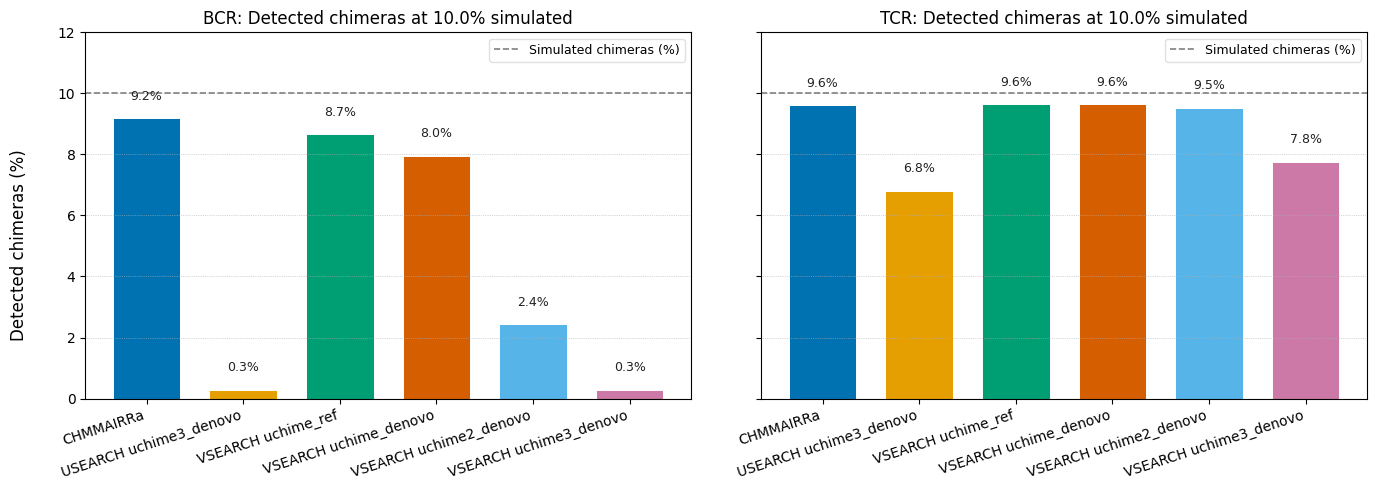

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/bcr_tcr_detected_side_by_side_10.0.png


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


METHOD_RENAME = {
    "USEARCH":         "USEARCH uchime3_denovo",
    "VSEARCH_denovo":  "VSEARCH uchime_denovo",
    "VSEARCH_uchime2": "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3": "VSEARCH uchime3_denovo",
    "VSEARCH_ref":     "VSEARCH uchime_ref",
}


method_order = [
    "CHMMAIRRa",
    "USEARCH uchime3_denovo",
    "VSEARCH uchime_ref",
    "VSEARCH uchime_denovo",
    "VSEARCH uchime2_denovo",
    "VSEARCH uchime3_denovo",
]

TARGET_SIM = 10.0  # z. B. 10.0, 15.0, 20.0 ...

def _prep(rec: str, target_sim: float):
    # nächstgelegene Simulationsstufe wählen
    levels = np.sort(m.loc[m["receptor"] == rec, "sim_percent"].unique())
    if len(levels) == 0:
        return None, None
    lvl = float(levels[np.argmin(np.abs(levels - float(target_sim)))])
    sub = m[(m["receptor"] == rec) & (np.isclose(m["sim_percent"], lvl, atol=1e-10))].copy()
    if sub.empty:
        return None, None

    # Methoden umbenennen & Reihenfolge fixieren
    sub["method"] = sub["method"].replace(METHOD_RENAME)
    sub["method"] = pd.Categorical(sub["method"], categories=method_order, ordered=True)
    sub = sub.dropna(subset=["method"]).sort_values("method")

    #  detected % = recall * sim_percent
    sub["detected_pct"] = sub["recall"] * sub["sim_percent"]
    return sub, lvl

def plot_detected_side_by_side(target_sim: float):
    sub_bcr, lvl_bcr = _prep("BCR", target_sim)
    sub_tcr, lvl_tcr = _prep("TCR", target_sim)

    if sub_bcr is None and sub_tcr is None:
        print("[Info] No data for BCR/TCR."); return

    # Gemeinsame Y-Achse bestimmen
    ymax_vals = []
    for sub, lvl in [(sub_bcr, lvl_bcr), (sub_tcr, lvl_tcr)]:
        if sub is not None:
            ymax_vals.append(float(sub["detected_pct"].max()))
        if lvl is not None:
            ymax_vals.append(float(lvl))
    ymax = (max(ymax_vals) if ymax_vals else 1.0) * 1.10 + 1.0

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    for ax, (rec, sub, lvl) in zip(axes, [("BCR", sub_bcr, lvl_bcr), ("TCR", sub_tcr, lvl_tcr)]):
        if sub is None:
            ax.axis("off"); ax.set_title(f"{rec}: no data"); continue

        methods = sub["method"].astype(str).tolist()
        heights = sub["detected_pct"].values
        x = np.arange(len(methods))
        width = 0.7

        # Balken
        ax.bar(
            x, heights, width,
            color=[PALETTE.get(mn, "#777") for mn in methods],
            edgecolor="white", linewidth=0.7
        )

        # Referenzlinie (simulierte %)
        ax.axhline(lvl, color="gray", linestyle="--", linewidth=1.2)
        ref_handle = Line2D([0],[0], color="gray", linestyle="--", linewidth=1.2,
                            label="Simulated chimeras (%)")
        ax.legend([ref_handle], ["Simulated chimeras (%)"],
                  loc="upper right", frameon=True, framealpha=0.9,
                  edgecolor="#dddddd", fontsize=9)

        # Werte über den Balken
        for xi, h in zip(x, heights):
            ax.text(xi, h + 0.5, f"{h:.1f}%", ha="center", va="bottom", fontsize=9, color="#222")

        # Achsen & Layout
        ax.set_ylim(0, ymax)
        ax.set_xticks(x)
        ax.set_xticklabels(methods, rotation=18, ha="right")
        #ax.set_xlabel("Methods")
        ax.grid(axis="y", linestyle=":", linewidth=0.5)
        ax.set_title(f"{rec}: Detected chimeras at {lvl:.1f}% simulated")

    fig.supylabel("Detected chimeras (%)")
    plt.tight_layout()
    out = OUT_DIR / f"bcr_tcr_detected_side_by_side_{TARGET_SIM:.1f}.png"
    plt.savefig(out, dpi=160)
    plt.show()
    print("Saved:", out)

# Run
plot_detected_side_by_side(TARGET_SIM)


/tmp/ipykernel_112321/3390418197.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base = (sub.groupby("method", as_index=False)[METRICS].mean())


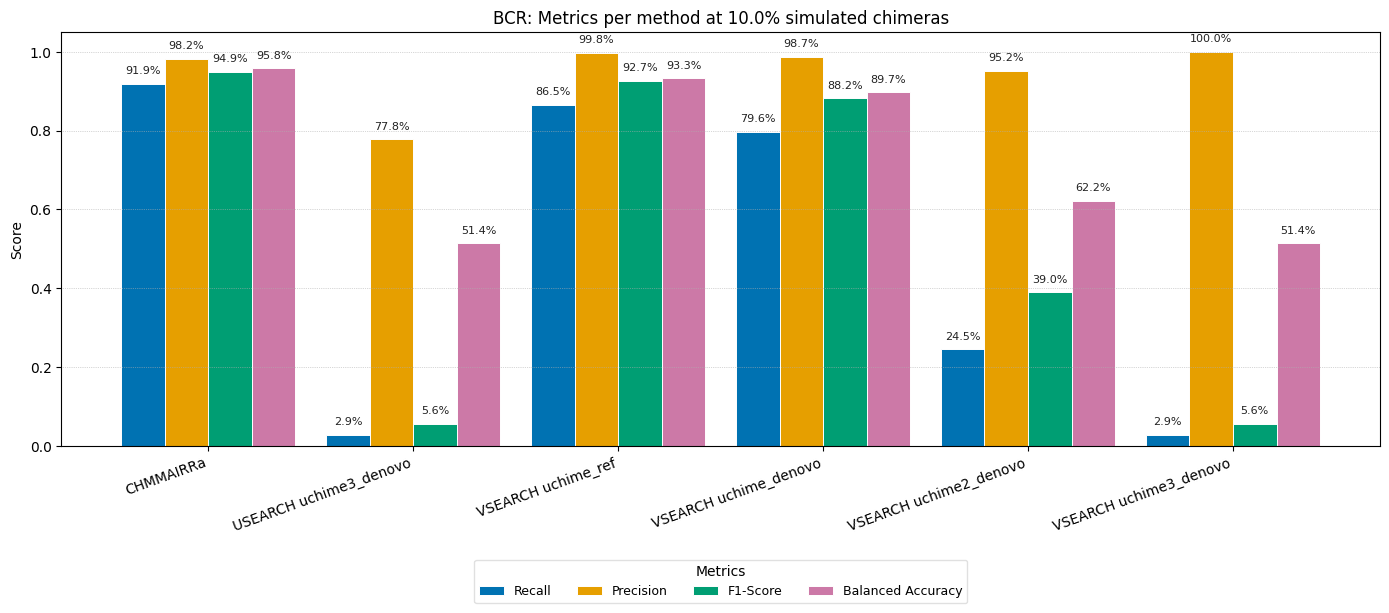

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/bcr_metrics_at_10.0.png


/tmp/ipykernel_112321/3390418197.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base = (sub.groupby("method", as_index=False)[METRICS].mean())


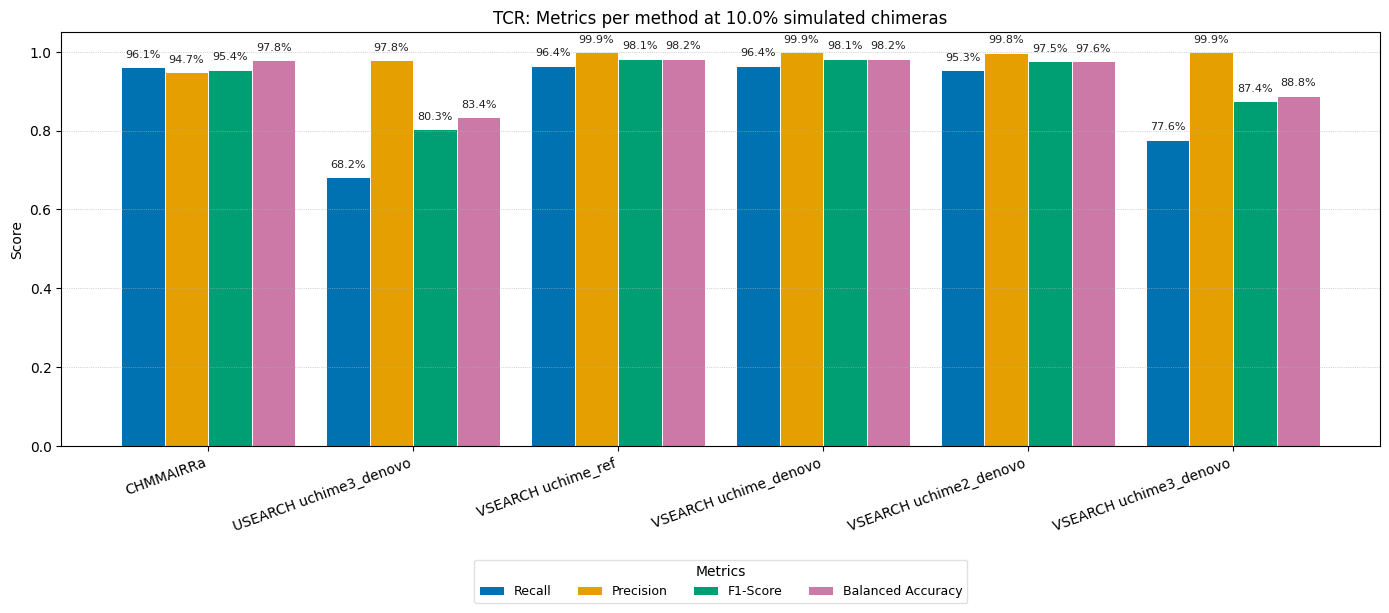

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/tcr_metrics_at_10.0.png


In [ ]:

TARGET_SIM = 10.0   
METRICS    = ["recall","precision","f1","bal_acc"]
METRIC_LABELS = {
    "recall":   "Recall",
    "precision":"Precision",
    "f1":       "F1-Score",
    "bal_acc":  "Balanced Accuracy",
}
METRIC_COLORS = {
    "recall":   "#0072B2",
    "precision":"#E69F00",
    "f1":       "#009E73",
    "bal_acc":  "#CC79A7",
}

def plot_metrics_at_level(rec: str, target_sim: float):
    sub = m[(m["receptor"]==rec) & np.isclose(m["sim_percent"], target_sim, atol=1e-6)]
    if sub.empty:
        print(f"[Info] No data for {rec} at sim={target_sim}")
        return

   
    base = (sub.groupby("method", as_index=False)[METRICS].mean())
    base["method"] = pd.Categorical(base["method"], categories=method_order, ordered=True)
    base = base.sort_values("method")

    methods = base["method"].astype(str).tolist()
    x_methods = np.arange(len(methods))
    n_metrics = len(METRICS)
    width = 0.85 / n_metrics   # Clusterbreite

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
   
    ax.grid(False)                                
    ax.xaxis.grid(False, which="both")            
   
    ax.yaxis.grid(True, linestyle=":", linewidth=0.5)

    # Balken zeichnen
    handles = []
    for i, met in enumerate(METRICS):
        offset = (i - (n_metrics-1)/2) * width
        vals = base[met].values
        bars = ax.bar(
            x_methods + offset, vals, width,
            label=METRIC_LABELS[met],
            color=METRIC_COLORS.get(met, "#999999"),
            edgecolor= "white", linewidth=0.7
        )
        handles.append(bars[0])
        # Prozentlabels
        for xi, v in zip(x_methods + offset, vals):
            ax.text(xi, v + 0.02, f"{v*100:.1f}%",
                    ha="center", va="bottom", fontsize=8, color="#222")

    # Achsen
    ax.set_xticks(x_methods)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(f"{rec}: Metrics per method at {target_sim:.1f}% simulated chimeras")
    ax.grid(axis="y", linestyle=":", linewidth=0.5)


    ax.legend(handles, [METRIC_LABELS[mn] for mn in METRICS],
              loc="upper center", bbox_to_anchor=(0.0, -0.38, 1.0, 0.12),
              ncol=4, frameon=True, framealpha=0.9,
              edgecolor="#dddddd", title="Metrics", title_fontsize=10, fontsize=9)
    plt.gcf().subplots_adjust(bottom=0.34)

    plt.tight_layout()
    out = OUT_DIR / f"{rec.lower()}_metrics_at_{target_sim:.1f}.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)

# Aufruf: für BCR & TCR 
for rec in ["BCR","TCR"]:
    plot_metrics_at_level(rec, TARGET_SIM)


In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from pathlib import Path
import pandas as pd

# ===== Pfade anpassen =====
ROOT    = Path("/home-link/zxozk31/Analyse_cons_count/Results_vsearch_unsimulated2")
OUT_CSV = Path("/home-link/zxozk31/Analyse_cons_count/Results_analyse/unsim_usearch_only.csv")

def fasta_count(path: Path) -> int:
    if not path or not path.exists():
        return 0
    n = 0
    with path.open("r", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            if line.startswith(">"):
                n += 1
    return n

def find_first(p: Path, patterns: list[str]) -> Path | None:
    for pat in patterns:
        hits = sorted(p.glob(pat))
        if hits:
            return hits[0]
    return None

rows = []
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# Kandidaten-Ordner: *_chimera_out
for rd in sorted(p for p in ROOT.iterdir() if p.is_dir() and p.name.endswith("_chimera_out")):
    sample = rd.name.removesuffix("_chimera_out")

    # 1) Deine Ziel-Variante (ohne "all"): <sample>_ch.fa / <sample>_nonch.fa
    chim_fa = find_first(rd, [f"{sample}_ch.fa"])
    non_fa  = find_first(rd, [f"{sample}_nonch.fa"])

    # 2) Fallbacks (falls Namen leicht variieren)
    if chim_fa is None and non_fa is None:
        chim_fa = find_first(rd, [f"{sample}_all_ch.fa", "*_all_ch.fa", "chimeras_*.fa"])
        non_fa  = find_first(rd, [f"{sample}_all_nonch.fa", "*_all_nonch.fa", "nonchimeras_*.fa"])

    # Wenn weiterhin nichts vorhanden ist, überspringen
    if chim_fa is None and non_fa is None:
        continue

    n_chim = fasta_count(chim_fa) if chim_fa else 0
    n_non  = fasta_count(non_fa)  if non_fa  else 0
    n_tot  = n_chim + n_non
    pct    = round(100.0 * n_chim / n_tot, 2) if n_tot else 0.0

    rows.append({
        "sample": sample,
        "method": "USEARCH",
        "n_total": n_tot,
        "n_chim": n_chim,
        "n_nonchim": n_non,
        "pct_chim": pct,
        "path_chim": str(chim_fa) if chim_fa else "",
        "path_nonchim": str(non_fa) if non_fa else "",
    })

df = pd.DataFrame(rows, columns=[
    "sample","method","n_total","n_chim","n_nonchim","pct_chim","path_chim","path_nonchim"
])
if not df.empty:
    df.sort_values(["sample","method"], inplace=True, kind="stable")
df.to_csv(OUT_CSV, index=False)
print(f"Wrote {len(df)} rows to {OUT_CSV}")


Wrote 12 rows to /home-link/zxozk31/Analyse_cons_count/Results_analyse/unsim_usearch_only.csv


/tmp/ipykernel_112321/462281737.py:105: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_weighted_mean)


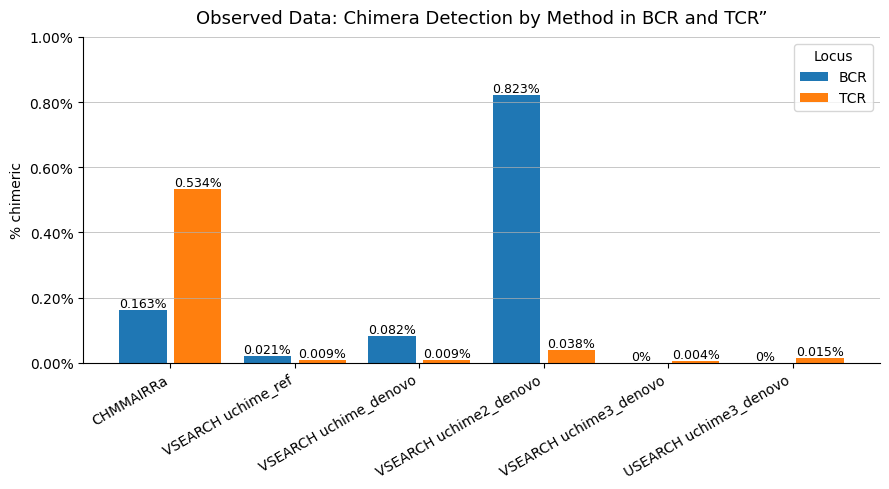

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


CSV_IN   = "/home-link/zxozk31/Analyse_cons_count/Results_analyse/unsimulated_combined_allmethods.csv"
WEIGHTED = True  # True: gewichtetes Mittel nach n_total; False: ungewichtet

preferred = [
    "CHMMAIRRa",
    "VSEARCH uchime_ref", "VSEARCH uchime_denovo", "VSEARCH uchime2_denovo", "VSEARCH uchime3_denovo",
    "USEARCH uchime3_denovo",
]


METHOD_MAP = {
    
    "CHMMAIRRa": "CHMMAIRRa",
    
    "VSEARCH_denovo":    "VSEARCH uchime_denovo",
    "VSEARCH_ref":       "VSEARCH uchime_ref",
    "VSEARCH_uchime2":   "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3":   "VSEARCH uchime3_denovo",
   
    "USEARCH":           "USEARCH uchime3_denovo",
    "USEARCH_denovo":    "USEARCH uchime_denovo",
    "USEARCH_ref":       "USEARCH uchime_ref",
    "USEARCH_uchime2":   "USEARCH uchime2_denovo",
    "USEARCH_uchime3":   "USEARCH uchime3_denovo",

    "VSEARCH (denovo)":  "VSEARCH (uchime_denovo)",
    "VSEARCH (ref)":     "VSEARCH (uchime_ref)",
    "VSEARCH (uchime2)":"VSEARCH (uchime2_denovo)",
    "VSEARCH (uchime3)":"VSEARCH (uchime3_denovo)",
    "USEARCH (denovo)":  "USEARCH (uchime_denovo)",
    "USEARCH (ref)":     "USEARCH (uchime_ref)",
    "USEARCH (uchime2)":"USEARCH (uchime2_denovo)",
    "USEARCH (uchime3)":"USEARCH (uchime3_denovo)",
}

df = pd.read_csv(CSV_IN)

def infer_locus(s: str) -> str:
    s = str(s).upper()
    if "BCR" in s or "_IG_" in s or "_IGBLAST_IG_" in s:
        return "BCR"
    if "TCR" in s or "_TR_" in s or "_IGBLAST_TR_" in s:
        return "TCR"
    return "UNKNOWN"

df["locus"] = df["sample"].apply(infer_locus)

# PBMC 10k/20k zusammen
LANE_RX = re.compile(r"_L00[1-4](?=_)")
def fold_pbmc_name(s: str) -> str:
    s = re.sub(r"^PBMC_10K_", "PBMC_", s, flags=re.IGNORECASE)
    s = re.sub(r"^PBMC_20K_", "PBMC_", s, flags=re.IGNORECASE)
    s = LANE_RX.sub("", s)
    return s

df["sample_folded"] = df["sample"].apply(fold_pbmc_name)


for c in ["n_total","n_chim","n_nonchim","pct_chim"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")


def normalize_method(m: str) -> str:
    m = str(m)
    if m in METHOD_MAP:
        return METHOD_MAP[m]
    if "_" in m:  # fallback "TOOL_mode" -> "TOOL (mode)"
        tool, mode = m.split("_", 1)
        return METHOD_MAP.get(m, f"{tool} ({mode})")
    return METHOD_MAP.get(m, m)

df["method_pretty"] = df["method"].apply(normalize_method)


present = [m for m in preferred if m in set(df["method_pretty"])]
present += [m for m in sorted(set(df["method_pretty"]) - set(present))]


def agg_weighted_mean(g: pd.DataFrame) -> float:
    if WEIGHTED:
        num = (g["pct_chim"].fillna(0) * g["n_total"].fillna(0)).sum()
        den = g["n_total"].fillna(0).sum()
        return float(num / den) if den > 0 else np.nan
    else:
        return float(g["pct_chim"].mean())

agg = (
    df[df["locus"].isin(["BCR","TCR"])]
    .groupby(["method_pretty","locus"])
    .apply(agg_weighted_mean)
    .rename("pct_chim_mean")
    .reset_index()
)

pivot = agg.pivot(index="method_pretty", columns="locus", values="pct_chim_mean")
pivot = pivot.reindex(present).dropna(how="all")


methods = pivot.index.tolist()
cols = [c for c in ["BCR","TCR"] if c in pivot.columns]
x = np.arange(len(methods))
bw = 0.38 if len(cols) == 2 else 0.6

fig, ax = plt.subplots(figsize=(max(9, 0.7 * len(methods)), 5))

bars = []
for i, c in enumerate(cols):
    offsets = (i - (len(cols)-1)/2) * (bw + 0.06)
    vals = pivot[c].values
    b = ax.bar(x + offsets, vals, width=bw, label=c)
    bars.append((b, c))

# Prozent-Achse + Grid
ax.yaxis.set_major_formatter(PercentFormatter(100, decimals=2))  
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Labels & Titel
ax.set_ylabel("% chimeric")
title_main = "Observed Data: Chimera Detection by Method in BCR and TCR”"
ax.set_title(f"{title_main}", fontsize=13, pad=10)
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=30, ha="right")


def fmt_pct(v: float, eps: float = 5e-4) -> str:
    """0% wenn |v| < eps, sonst mit 3 Nachkommastellen."""
    if np.isnan(v):
        return ""
    return "0%" if abs(v) < eps else f"{v:.3f}%"

for b, _ in bars:
    for r in b:
        v = r.get_height()
        ax.text(
            r.get_x() + r.get_width()/2, v,
            fmt_pct(v),
            ha="center", va="bottom", fontsize=9
        )


handles = [b for (b, c) in bars]   # Bar-Container
labels  = [c for (b, c) in bars]   # ["BCR","TCR"]
leg = ax.legend(
    handles=[b for (b, c) in bars],
    labels=[c for (b, c) in bars],
    title="Locus",
    loc="upper right",
)




ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()


/tmp/ipykernel_112321/2314147062.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base = (sub.groupby("method", as_index=False)[METRICS].mean())


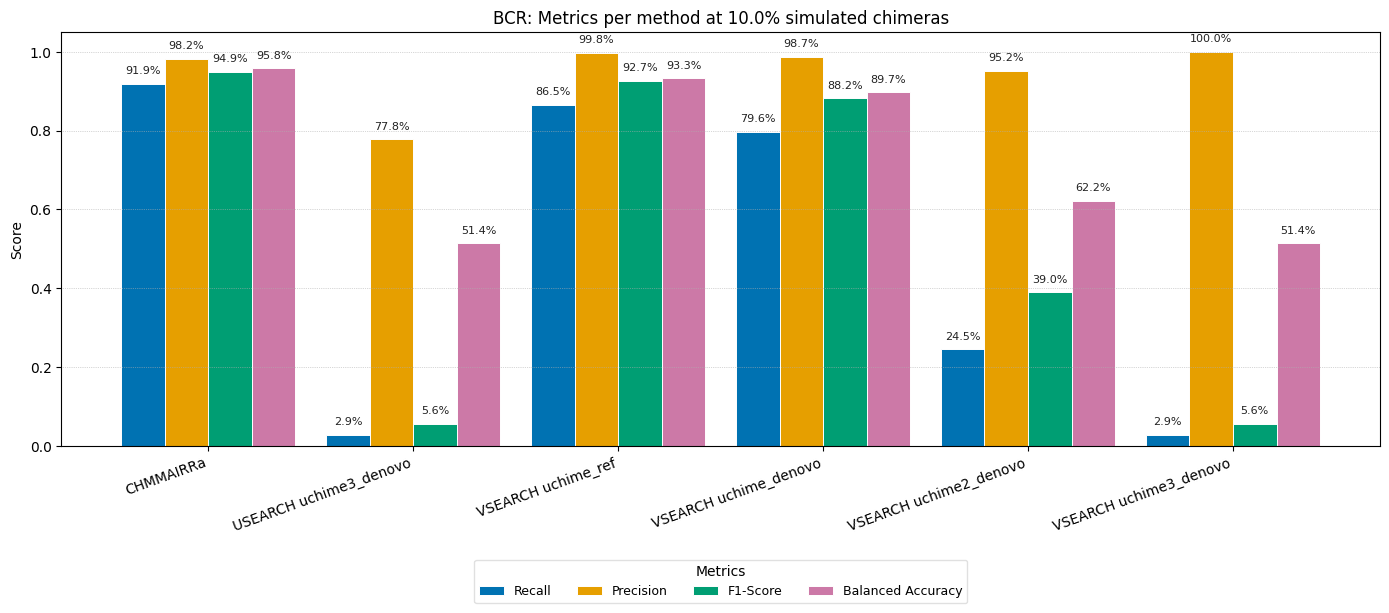

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/bcr_metrics_at_10.0.png


/tmp/ipykernel_112321/2314147062.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base = (sub.groupby("method", as_index=False)[METRICS].mean())


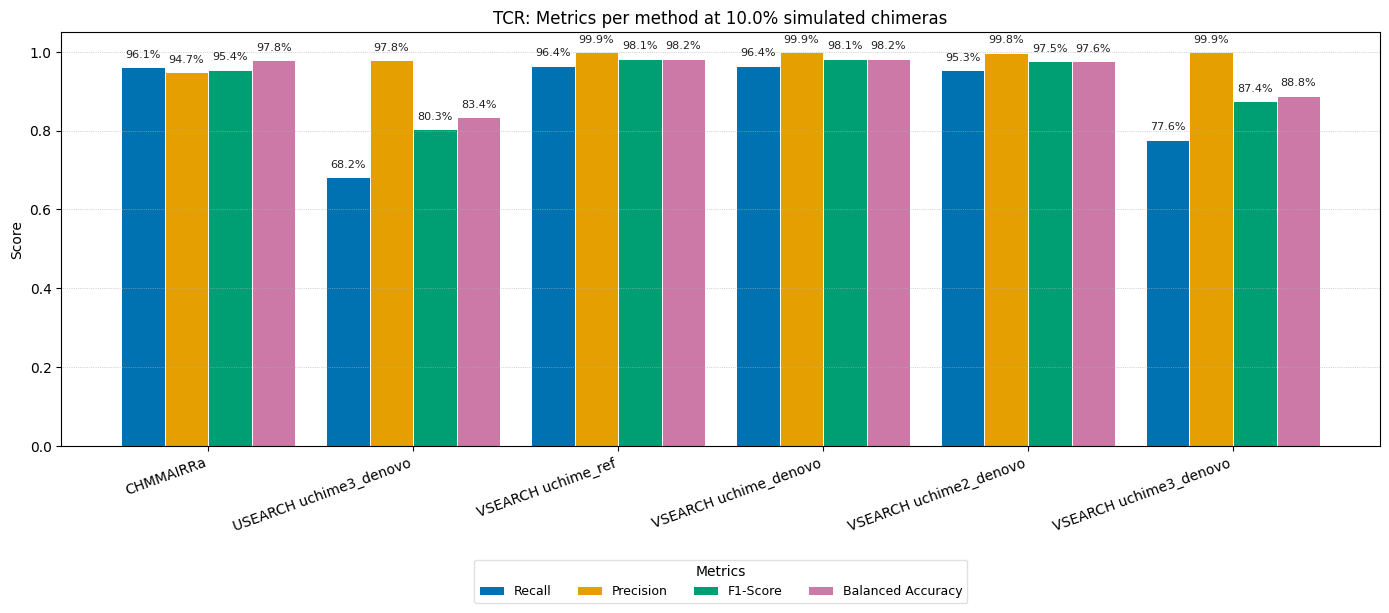

Saved: /home-link/zxozk31/Analyse_cons_count/Results_analyse/jupyter_selected_metrics/tcr_metrics_at_10.0.png


In [ ]:



METHOD_RENAME = {
    "USEARCH":         "USEARCH uchime3_denovo",
    "VSEARCH_denovo":  "VSEARCH uchime_denovo",
    "VSEARCH_uchime2": "VSEARCH uchime2_denovo",
    "VSEARCH_uchime3": "VSEARCH uchime3_denovo",
    "VSEARCH_ref":     "VSEARCH uchime_ref",
}


method_order = [
    "CHMMAIRRa",
    "USEARCH uchime3_denovo",
    "VSEARCH uchime_ref",
    "VSEARCH uchime_denovo",
    "VSEARCH uchime2_denovo",
    "VSEARCH uchime3_denovo",
]

TARGET_SIM = 10.0   # <-- hier gewünschte Simulation eintragen, z.B. 15.0
METRICS    = ["recall","precision","f1","bal_acc"]
METRIC_LABELS = {
    "recall":   "Recall",
    "precision":"Precision",
    "f1":       "F1-Score",
    "bal_acc":  "Balanced Accuracy",
}
METRIC_COLORS = {
    "recall":   "#0072B2",
    "precision":"#E69F00",
    "f1":       "#009E73",
    "bal_acc":  "#CC79A7",
}

def plot_metrics_at_level(rec: str, target_sim: float):
    sub = m[(m["receptor"]==rec) & np.isclose(m["sim_percent"], target_sim, atol=1e-6)].copy()
    if sub.empty:
        print(f"[Info] No data for {rec} at sim={target_sim}")
        return


    sub["method"] = sub["method"].replace(METHOD_RENAME)

  
    base = (sub.groupby("method", as_index=False)[METRICS].mean())
    base["method"] = pd.Categorical(base["method"], categories=method_order, ordered=True)
    base = base.dropna(subset=["method"]).sort_values("method")

    methods = base["method"].astype(str).tolist()
    x_methods = np.arange(len(methods))
    n_metrics = len(METRICS)
    width = 0.85 / n_metrics   # Clusterbreite

    plt.figure(figsize=(14, 6))
    ax = plt.gca()
    ax.grid(False)                                 
    ax.xaxis.grid(False, which="both")            
    ax.yaxis.grid(True, linestyle=":", linewidth=0.5)

    # Balken zeichnen
    handles = []
    for i, met in enumerate(METRICS):
        offset = (i - (n_metrics-1)/2) * width
        vals = base[met].values
        bars = ax.bar(
            x_methods + offset, vals, width,
            label=METRIC_LABELS[met],
            color=METRIC_COLORS.get(met, "#999999"),
            edgecolor="white", linewidth=0.7
        )
        handles.append(bars[0])
        # Prozentlabels
        for xi, v in zip(x_methods + offset, vals):
            ax.text(xi, v + 0.02, f"{v*100:.1f}%",
                    ha="center", va="bottom", fontsize=8, color="#222")

   
    ax.set_xticks(x_methods)
    ax.set_xticklabels(methods, rotation=20, ha="right")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(f"{rec}: Metrics per method at {target_sim:.1f}% simulated chimeras")
    ax.grid(axis="y", linestyle=":", linewidth=0.5)


    ax.legend(handles, [METRIC_LABELS[mn] for mn in METRICS],
              loc="upper center", bbox_to_anchor=(0.0, -0.38, 1.0, 0.12),
              ncol=4, frameon=True, framealpha=0.9,
              edgecolor="#dddddd", title="Metrics", title_fontsize=10, fontsize=9)
    plt.gcf().subplots_adjust(bottom=0.34)

    plt.tight_layout()
    out = OUT_DIR / f"{rec.lower()}_metrics_at_{target_sim:.1f}.png"
    plt.savefig(out, dpi=160, bbox_inches="tight")
    plt.show()
    print("Saved:", out)


for rec in ["BCR","TCR"]:
    plot_metrics_at_level(rec, TARGET_SIM)
